In [233]:
using Pkg
Pkg.activate("../..")

  Activating project at `c:\Users\ladis\GitHub\SparseSpikes`


In [234]:
using Plots, LinearAlgebra, LaTeXStrings, Random
using FFTW: fft, fftshift
using SparseSpikes

Define ground truth amplitudes and positions

In [235]:
domain = [0, 1]

x₀ = [0.4, 0.7]
a₀ = [1.5, -1.0]

μ₀ = DiscreteMeasure(x₀, a₀)

DiscreteMeasure{Float64}([0.4, 0.7], [1.5, -1.0], 1, 2)

In [236]:
# Define the number of Fourier coefficients
fc = 6 
n = 2fc + 1

# Define noise level
noise_level = 0.05

# Seed for noise
Random.seed!(12)

TaskLocalRNG()

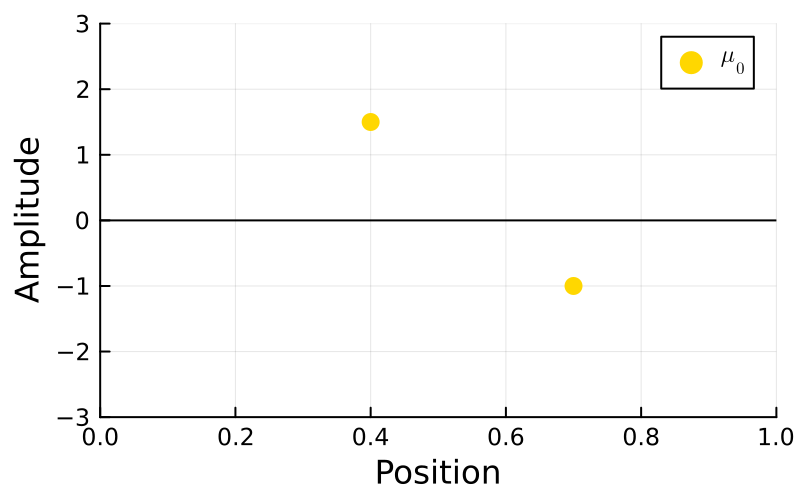

In [237]:
n_coarse_grid = 20
n_plt_grid = 1000

plt_grid = build_grid(domain, n_plt_grid)

plot_size = (400, 250) .* 1
plt = plot(xlims=extrema(domain), ylims=(-3, 3), xlabel="Position", ylabel="Amplitude", legend=:topright, size=plot_size, dpi=200)
hline!(plt, [0], linestyle=:solid, color=:black, label="")

plot_spikes!(plt, μ₀, color=:gold, label=L"μ_0")

In [238]:
ops = fourier_operators_1D(fc, plt_grid)

Operators(SparseSpikes.var"#ϕ!#fourier_operators_1D##93"{Float64, Vector{Float64}, Int64}(0.2773500981126146, [-37.69911184307752, -31.41592653589793, -25.132741228718345, -18.84955592153876, -12.566370614359172, -6.283185307179586, 0.0, 6.283185307179586, 12.566370614359172, 18.84955592153876, 25.132741228718345, 31.41592653589793, 37.69911184307752], 13), SparseSpikes.var"#ϕ#fourier_operators_1D##94"{SparseSpikes.var"#ϕ!#fourier_operators_1D##93"{Float64, Vector{Float64}, Int64}, Int64}(SparseSpikes.var"#ϕ!#fourier_operators_1D##93"{Float64, Vector{Float64}, Int64}(0.2773500981126146, [-37.69911184307752, -31.41592653589793, -25.132741228718345, -18.84955592153876, -12.566370614359172, -6.283185307179586, 0.0, 6.283185307179586, 12.566370614359172, 18.84955592153876, 25.132741228718345, 31.41592653589793, 37.69911184307752], 13), 13), SparseSpikes.var"#∇ϕ!#fourier_operators_1D##95"{Float64, Vector{ComplexF64}, Vector{Float64}, Int64}(0.2773500981126146, ComplexF64[-0.0 - 37.699111843

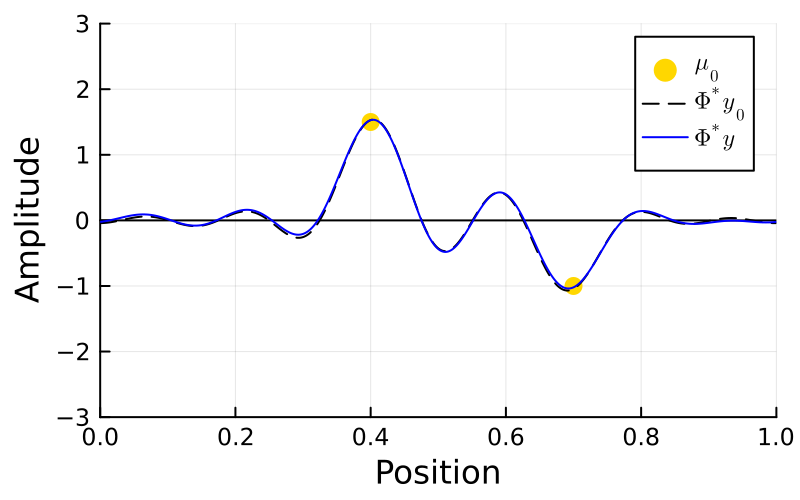

In [239]:
# Calculate the observation y₀ = Φμ₀
y₀ = ops.Φₓ(μ₀...)

# Add noise to the observation y = y₀ + ϵ
sigma = noise_level * norm(y₀)
ϵ = fftshift(fft(randn(length(y₀))))
ϵ = ϵ / norm(ϵ) * sigma
y = y₀ + ϵ

plt_obs = deepcopy(plt)

plot!(plt_obs, plt_grid, ops.Φₓᴴ(y₀), label=L"Φ^{\ast}y_0", color=:black, linestyle=:dash)
plot!(plt_obs, plt_grid, ops.Φₓᴴ(y), label=L"Φ^{\ast}y", color=:blue)

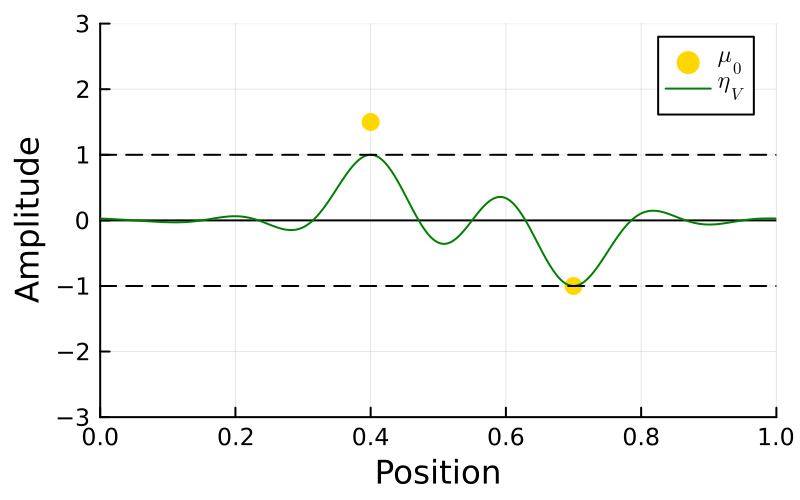

In [240]:
ηᵥ = ops.ηᵥ(μ₀...)

plt_cert = deepcopy(plt)

plot!(plt_cert, plt_grid, ηᵥ(plt_grid), label=L"η_V", color=:green)
hline!(plt_cert, [1, -1], linestyle=:dash, color=:black, label="")

## SDP

In [241]:
coarse_grid = build_grid(domain, n_coarse_grid)
λ_max = λ₀(coarse_grid, ops.ϕ, y, 1e-2)
println("Largest λ is $(round(λ_max, digits=3)).")

In [242]:
λ = 0.05

prob = BLASSO(y, ops, domain, n_coarse_grid, λ=λ)

prob_sdp = deepcopy(prob)

solve!(prob_sdp, :SDP)

Largest λ is 1.519.


DiscreteMeasure{Float64}([0.39910642402211743, 0.7019512372761523], [1.457407669853543, -0.9330072062061089], 1, 2)

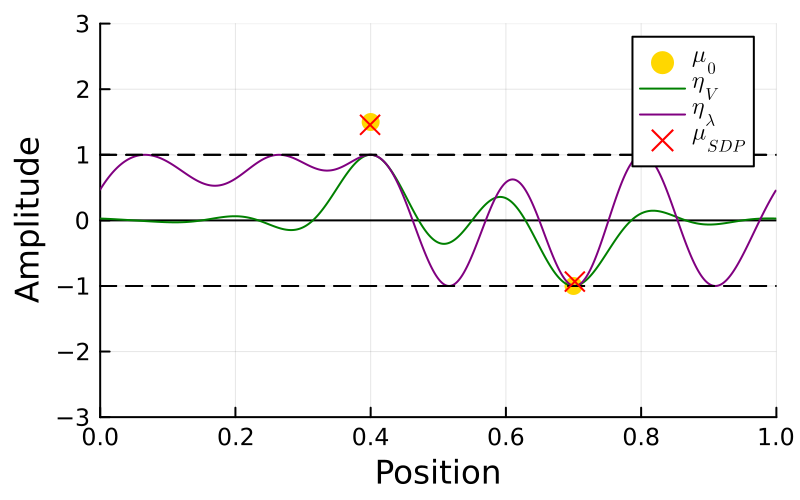

In [243]:
plt_sdp = deepcopy(plt_cert)

# dual polynomial
ηλ = ops.Φₓᴴ(prob_sdp.p, grid=plt_grid)
plot!(plt_sdp, plt_grid, ηλ, label=L"η_λ", color=:purple)
hline!(plt_sdp, [1, -1], linestyle=:dash, color=:black, label="")
plot_spikes!(plt_sdp, prob_sdp.μ, color=:red, label=L"μ_{SDP}", marker=:x, markerstrokewidth=2)

## Sliding Frank-Wolfe

In [244]:
prob_sfw = deepcopy(prob)
solve!(prob_sfw, :SFW, options=Dict(:maxits => 5))

SFW iterations:  2    Time: 0:00:01

BLASSO(ComplexF64[-0.4015517919910227 + 0.016732082331533518im, 0.6950650515740487 - 0.026053451063617186im, -0.42675138789016437 - 0.03896363190156324im, -0.07093875944503056 - 0.2365951775266546im, 0.32554016972063704 + 0.544528729349814im, -0.25061727841844 - 0.5257563466119971im, 0.1775543481278613 + 0.0im, -0.25061727841844 + 0.5257563466119971im, 0.32554016972063704 - 0.544528729349814im, -0.07093875944503056 + 0.2365951775266546im, -0.42675138789016437 + 0.03896363190156324im, 0.6950650515740487 + 0.026053451063617186im, -0.4015517919910227 - 0.016732082331533518im], Operators(SparseSpikes.var"#ϕ!#fourier_operators_1D##93"{Float64, Vector{Float64}, Int64}(0.2773500981126146, [-37.69911184307752, -31.41592653589793, -25.132741228718345, -18.84955592153876, -12.566370614359172, -6.283185307179586, 0.0, 6.283185307179586, 12.566370614359172, 18.84955592153876, 25.132741228718345, 31.41592653589793, 37.69911184307752], 13), SparseSpikes.var"#ϕ#fourier_operators_1D##94"{SparseSpikes.

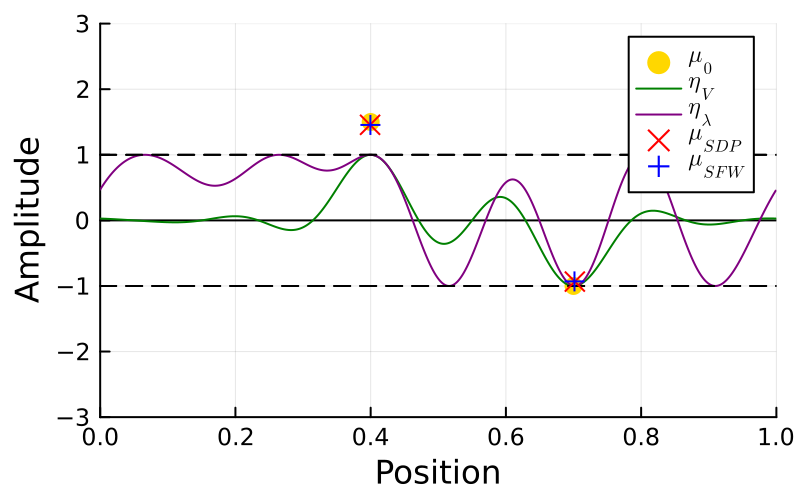

In [245]:
plt_sfw = deepcopy(plt_cert)

plot!(plt_sfw, plt_grid, ηλ, label=L"η_λ", color=:purple)
hline!(plt_sfw, [1, -1], linestyle=:dash, color=:black, label="")
plot_spikes!(plt_sfw, prob_sdp.μ, color=:red, label=L"μ_{SDP}", marker=:x, markerstrokewidth=2)
plot_spikes!(plt_sfw, prob_sfw.μ, color=:blue, label=L"μ_{SFW}", marker=:cross, markerstrokewidth=2)